# Лабораторная работа №9. Факторный анализ.
## Шкуратова Д.В. МКТ

### Задачи факторного анализа:
1. Сокращение числа переменных
2. Построение новых обобщенных показателей
3. Наглядное представление многомерных наблюдений
4. Выявление групп взаимозависимых переменных

С помощью метода главных компонент мы хотим уменьшить размерность данных: какие факторы можно отбросить?



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import FactorAnalysis
from prettytable import PrettyTable

### Первичный анализ данных и подготовка к факторному анализу

In [3]:
data = pd.read_csv('../data/StudentsPerformance.csv')
data.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [4]:
data.isna().sum()

gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64

In [5]:
# Количество уникальных значений для каждой переменной
data.nunique()

gender                          2
race/ethnicity                  5
parental level of education     6
lunch                           2
test preparation course         2
math score                     81
reading score                  72
writing score                  77
dtype: int64

### Обработка категориальных переменных

Преобразуем категориальные переменные в числа с помощью LabelEncoder

In [6]:
from sklearn.preprocessing import LabelEncoder


categorical_columns = data.columns
encoder = LabelEncoder()
for col in categorical_columns:
    data[col] = encoder.fit_transform(data[col])

In [7]:
data.describe()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.482000,2.174000,2.486000,0.645000,0.642000,46.145000,41.212000,44.104000
std,0.499926,1.157179,1.829522,0.478753,0.479652,14.980667,14.382695,15.043254
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,1.000000,0.000000,0.000000,37.000000,31.000000,33.750000
50%,0.000000,2.000000,2.000000,1.000000,1.000000,46.000000,42.000000,45.000000
75%,1.000000,3.000000,4.000000,1.000000,1.000000,57.000000,51.000000,55.000000
max,1.000000,4.000000,5.000000,1.000000,1.000000,80.000000,71.000000,76.000000


In [8]:
# Стандартизация данных
scaler = StandardScaler()
Z = scaler.fit_transform(data)

После стандартизации сумма всех собственных чисел матрицы корреляций $R$ = $m$, где $m$- число переменных, так как дисперсия стандартизированных данных $Var(Z_i)= 1$.
Дисперсия измеряет количество информации, которое содержится в переменной. Считаем, что каждая переменная вносит одинаковый вклад.
 
Вычислив собственные значения матрицы корреляций и расположив их в порядке возрастания, мы можем сократить размерность данных, если например, из 8 переменных 5 описывают больше 90% информации.

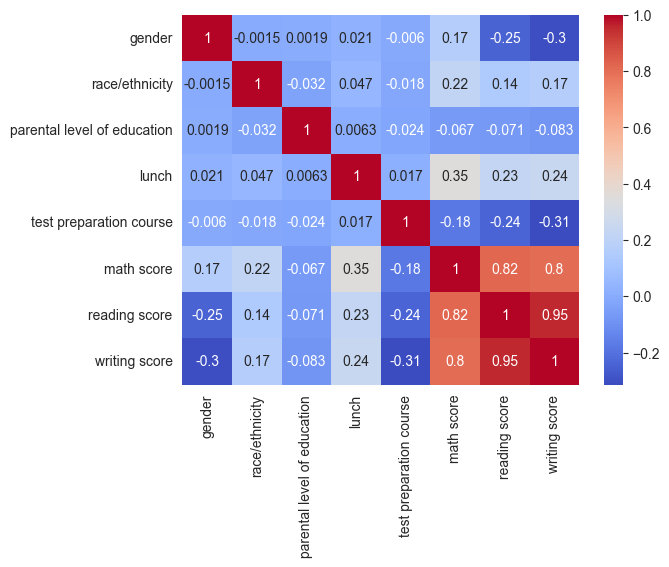

In [9]:
correlation_matrix =data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

По матрице корреляций видим, что есть большая корреляция между переменными, отвечающими за результаты экзаменов, между остальными переменными корреляция незначительна. Факторного анализа неэффективен, наблюдаемые переменные плохо скоррелированы друг с другом.

Проверим корреляции тестом Кайзера-Мейера-Олкина 

In [10]:
from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all, kmo_model = calculate_kmo(Z)
print("KMO:", kmo_model)

KMO: 0.5901561936843459


Получили $KMO \in (0.5, 0.7]$ -  приемлемая адекватность для проведения факторного анализа 

<Figure size 1000x1000 with 0 Axes>

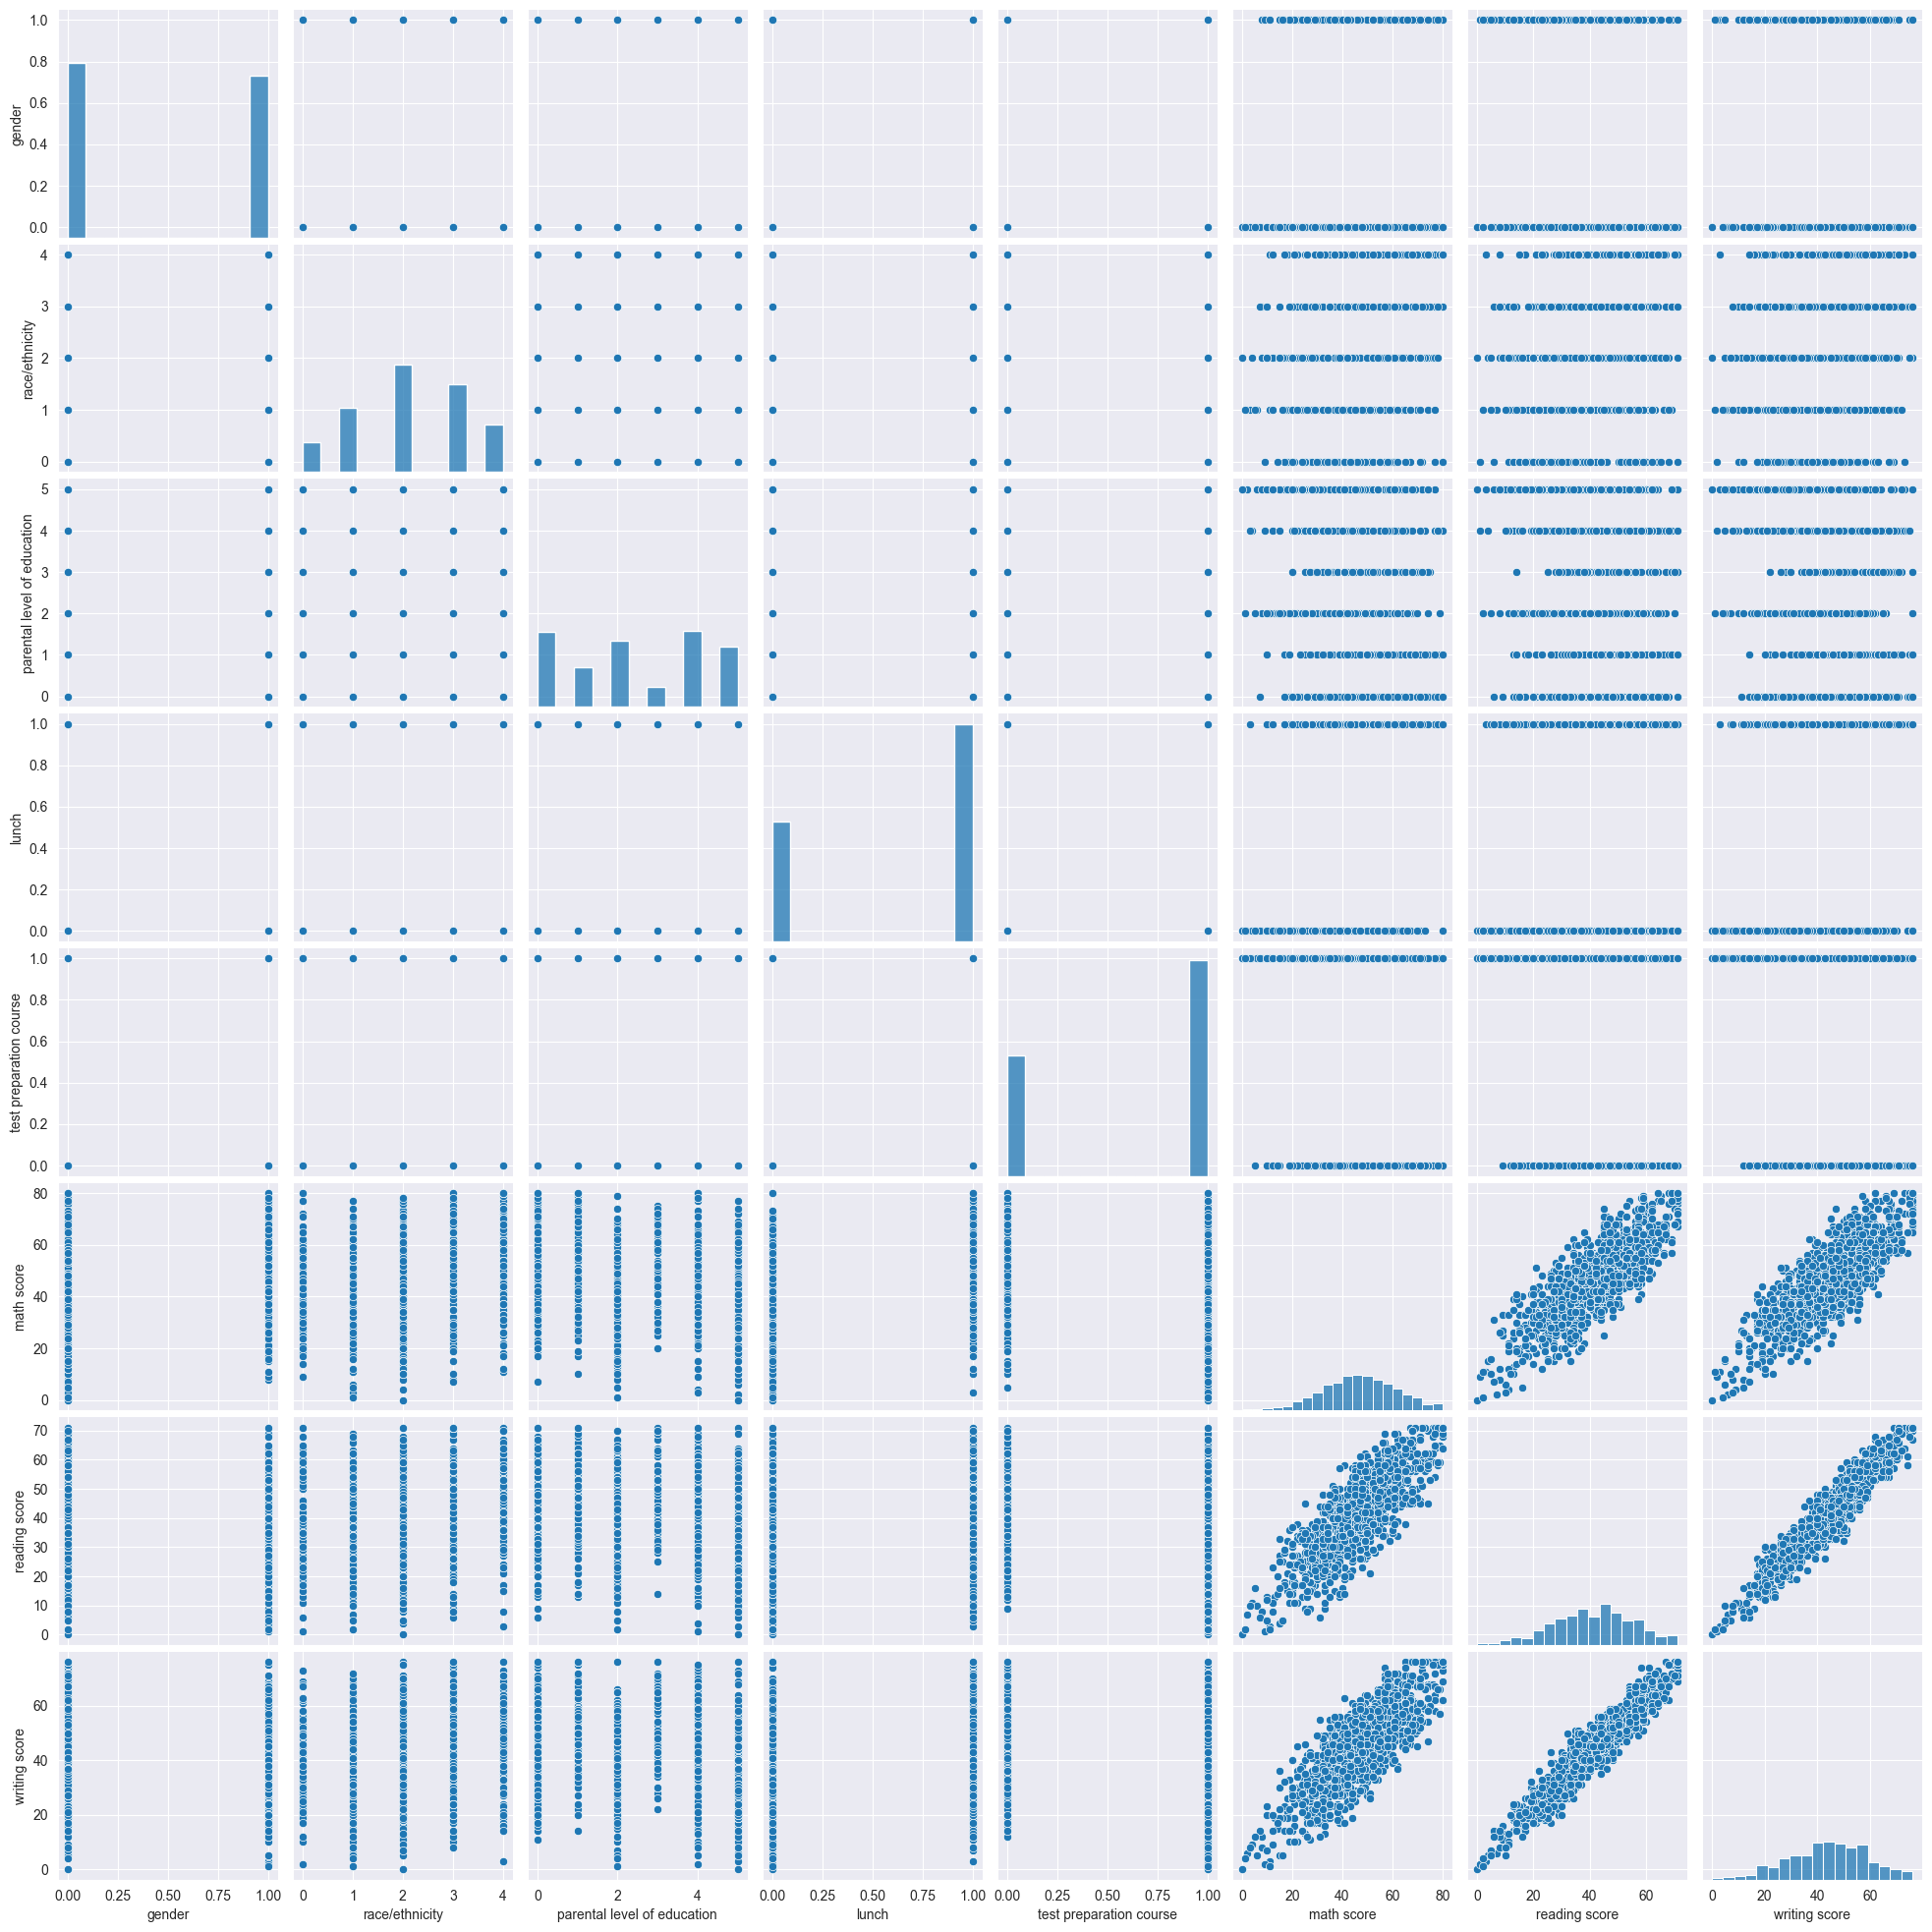

In [11]:
fig = plt.figure(figsize=(10, 10)) 
sns.pairplot(data, diag_kind='hist')

По графику видим, что попарная связь переменных, отвечающих за результат экзамена похожа на линейную, одно из предположений для реализации метода главных компонент выполняется. 

К проблемам можно отнести наличие 5 категориальных переменных, для которых метод не очень хорошо работает.

## Реализация метода главных компонент
#### Есть несколько критериев оценки факторов при сокращении размерности данных:
1. Ограничиться факторами, которые объясняют 90% данных
2. Оставить только те факторы, у которых собственное значение больше 1 (т.к. фактор с $\lambda < 1$, содержит меньше информации, чем любая из исходных переменных.)
3. Более слабый критерий п.2: собственное значение должно быть больше 0.8
- Выберем число компонент, описывающих ~90% данных
$$ ExplainedVarianceRatio_i = \frac{\lambda_i}{\sum_{i=1}^n \lambda_i} = \frac{\lambda_i}{m}$$ 

In [24]:
pca = PCA(n_components=5) 
pca_data = pca.fit_transform(Z)
table = PrettyTable()
table.field_names = ['Val', '1', '2', '3', '4', '5']
table.add_row(['Cобственные значения матрицы корреляций:',*np.round(pca.explained_variance_,4)])
table.add_row(['Explained Variance Ratio:',*np.round(pca.explained_variance_ratio_,4)])
table.add_row(['Префиксная сумма отношения с.з. к количеству переменных:',*np.round(np.cumsum(pca.explained_variance_ratio_),4)])
table

Val,1,2,3,4,5
Cобственные значения матрицы корреляций:,3.0026,1.1767,1.0336,0.9959,0.95
Explained Variance Ratio:,0.375,0.1469,0.1291,0.1244,0.1186
Префиксная сумма отношения с.з. к количеству переменных:,0.375,0.5219,0.651,0.7753,0.894


Для удобства выведем полученную матрицу компонент в виде тепловой карты

<Axes: >

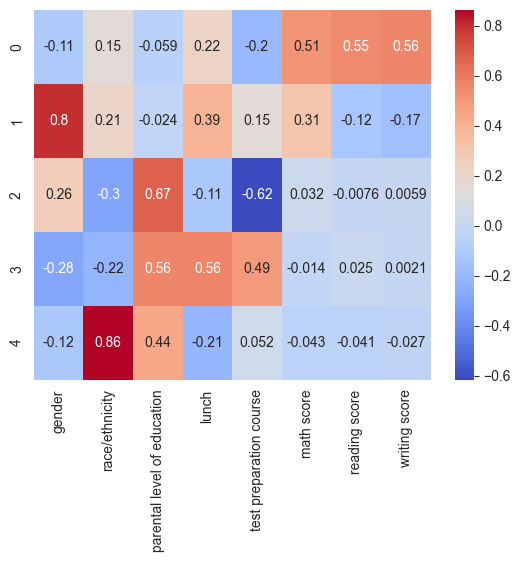

In [13]:
components_df = pd.DataFrame(pca.components_, columns=data.columns)
sns.heatmap(components_df, annot=True, cmap='coolwarm')

Метод главных компонент показывает какие признаки имеют наибольшую вариативность и позволяет уменьшить размерность данных, в отличие от метода главных факторов, с помощью которого можно выявить скрытые факторы, объясняющие общую структуру данных.

К минусам метода главных компонент относятся: сложность интерпретации данных, трудности при работе с категориальными переменными. К плюсам - отсутствие строгих предположений о данных, вычислительная эффективность. 

Для поиска и интерпретации скрытых факторов реализуем факторный анализ.

## Факторный анализ

$$ X = AF + U,$$
где 
- X - матрица со значениеями наблюдаемых переменных
- $A$ - матрица факторных нагрузок
- $F$ - факторы,
- $U$ - уникальные факторы

In [14]:
# Функция для вывода полученной матрицы факторных нагрузок
def print_component(factors):
    table = PrettyTable()
    table.field_names = data.columns.insert(0, 'Factor')
    for i, j in enumerate(factors.components_):
        table.add_row([i+1, *j])
    return table

In [15]:
fa = FactorAnalysis(n_components=4)  
fa.fit_transform(Z)
print_component(fa)

Factor,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
1,0.15894323769895544,-0.1842594197912245,0.07757830211621075,-0.2867520294905811,0.2646857999388967,-0.9010990503995855,-0.9673906907757364,-0.9666385768953104
2,0.880409394774851,0.08310117764594516,2.7403487186265185e-05,0.16287151578938436,0.06601265002821828,0.381806957254852,-0.12697543527849764,-0.17918829395951869
3,0.2289848576813634,-0.1022177728690971,0.010533360968940513,-0.21955923874756483,-0.6279009764813591,-0.08336576222003915,0.01807229410107151,0.05409811281277963
4,0.12627405610960374,-0.15085879384110829,-0.024422562675467423,-0.19130298047220679,0.29515121571570624,-0.05535408128207261,0.1173199626772559,-0.04082257984506349


4-й фактор слабо коррелирует со всеми переменными, уменьшим количество компонент до 3.


In [16]:
fa = FactorAnalysis(n_components=3)  
fa.fit_transform(Z)
print_component(fa)

Factor,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
1,0.17952708870555595,-0.18683216520806648,0.08112600064988171,-0.2854547403406299,0.287034131912085,-0.8915732577237684,-0.9562814287164566,-0.9824016154757065
2,0.7436759817792595,0.1092682473166263,0.011014687825816785,0.211410496263934,0.17570747095087846,0.4396981836096148,-0.08510976196929841,-0.17192442056437884
3,0.24740564426204112,-0.02547964150813685,0.04660109538331214,-0.08899478565039697,-0.7666775730295434,-0.0016008030860921875,-0.05966289990501235,0.00170046098743408


По матрице факторных нагрузок можем попытаться интерпретировать полученные латентные факторы

1. Факторные нагрузки для результатов экзамена по абсолютной величине близки к 1, можем интерпретировать его как фактор, отвечающий за общую успеваемость.
2. Второй фактор скоррелирован с переменными gender и math score, можем расценивать его как фактор, связанный с математическими способностями ученика в зависимости от пола 
3. Третий фактор имеет большую корреляцию всего с одной переменной - test preparation course, он может отвечать за уровень подготовки к тесту.

### Матрица $U$  уникальных факторов

Рассмотрим таблицу  дисперсий переменных, объясненных
уникальными факторами. Чем меньше значение дисперсии, тем лучше факторы описывают переменные.

In [17]:
pd.Series(fa.noise_variance_, data.columns)

gender                         0.353381
race/ethnicity                 0.952506
parental level of education    0.991128
lunch                          0.865896
test preparation course        0.299311
math score                     0.011806
reading score                  0.074715
writing score                  0.005335
dtype: float64

Лучше всего факторы описывают переменные math score, reading score, writing score, gender и test preparation course,
меньше всего - race/ethnicity, parental level of education, lunch, дисперсия для уникальных факторов $\in [0.86, 0.99]$, поэтому их следует исключить из факторного анализа.

In [18]:
# Значения факторов
scores = pd.DataFrame(fa.transform(Z), columns=['factor1', 'factor2', 'factor3'])
scores.head()

,factor1,factor2,factor3
0,-0.397390,0.006837,-0.862663
1,-1.063068,-1.609689,0.613830
2,-1.709977,0.097275,-1.171165
3,1.544338,0.285753,-0.225597
4,-0.537791,0.478016,-0.516505


По первому фактору можем выделить студентов с наилучшими результатами за все три экзамена, для них значение фактора будет минимальным, для студентов с наихудшими результатами - максимальным.